In [1]:
import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob


def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str) -> dict:
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """

    with open(filename, "r") as f:
        header = list(filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")


bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))
read_lightcurve_file(bulla_grid_files[0]).describe()

In [3]:
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

def resample_series(X, num_points, new_length=100):
    """
    Resamples time series data to a fixed number of points using linear interpolation.
    
    Parameters:
        X (array): The input array containing time series data of shape (n_samples, n_timesteps, n_features).
        num_points (int): The number of time points to use from the original series for interpolation.
        new_length (int): The new number of time points desired for each series.
    
    Returns:
        numpy.array: The resampled time series data.
    """
    X_resampled = np.zeros((X.shape[0], new_length, X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            interp_func = interp1d(np.arange(num_points), X[i, :num_points, j], kind='linear', fill_value='extrapolate')
            X_resampled[i, :, j] = interp_func(np.linspace(0, num_points - 1, new_length))
    return X_resampled

In [4]:
def fwhm(lightcurve, filter):
    '''
    Function to calculate the duration the lightcurve is brighter than the half maximum value. Here, lightcurves are in magnitudes, so the "maximum" is the most negative value. less negative values are dimmer than more negative values.
    
    Args:
    - lightcurve (string): path to lightcurve. Read in by read_lightcurve_file (NMMA Note: using pandas here, will have to later adapt to using the dict as is standard for the NMMA version of function)
    - filter (string, list): filter(s) to calculate FWHM for. If multiple filters are provided in a list, the function will return each filter's FWHM as a dictionary.
    
    Returns:
    - FWHM (float, dict): dictionary where each key corresponds to a filter and each value is a tuple containing the maximum magnitude in the first index and the duration it is brighter than half maximum in the second index.
    
    TODO: make more resilient to positive magnitudes, switch to using dict as input
    '''
    
    ## read in lightcurve
    lc = read_lightcurve_file(lightcurve)
    
    ## if filter is a string, convert to list
    if isinstance(filter, str):
        filter = [filter]
    
    ## ensure all filters are in the lightcurve 
    for f in filter:
        if f not in lc.columns:
            raise ValueError(f"Filter {f} not in lightcurve. Available filters are {lc.columns.pop('t')}")
    
    ## calculate the maximum magnitude for each filter and then calculate the duration it is brighter than half the maximum
    FWHM = {}
    for f in filter:
        max_mag = lc[f].min()
        bright = lc[lc[f] < max_mag/2]
        duration = bright["t"].max() - bright["t"].min()
        FWHM[f] = (max_mag, duration)
    return FWHM


In [5]:
fwhm(bulla_grid_files[0], "ztfg")

{'ztfg': (-16.23, 4.009)}

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize an empty list to store the results
df_list = []
filters = ['ztfg', 'ztfr', 'ztfi']
# Loop through the files
for f in bulla_grid_files:
    # Loop through the filters
    for filt in filters:
        # Calculate the FWHM
        fwhm_value = fwhm(f, filt)
        # Create a temporary DataFrame and append it to the list
        df_temp = pd.DataFrame({'file': [f], 'filter': [filt], 'peak_magnitude': [fwhm_value[filt][0]], 'fwhm': [fwhm_value[filt][1]]})
        df_list.append(df_temp)

# Concatenate all the dataframes in the list
df_fwhm = pd.concat(df_list, ignore_index=True)

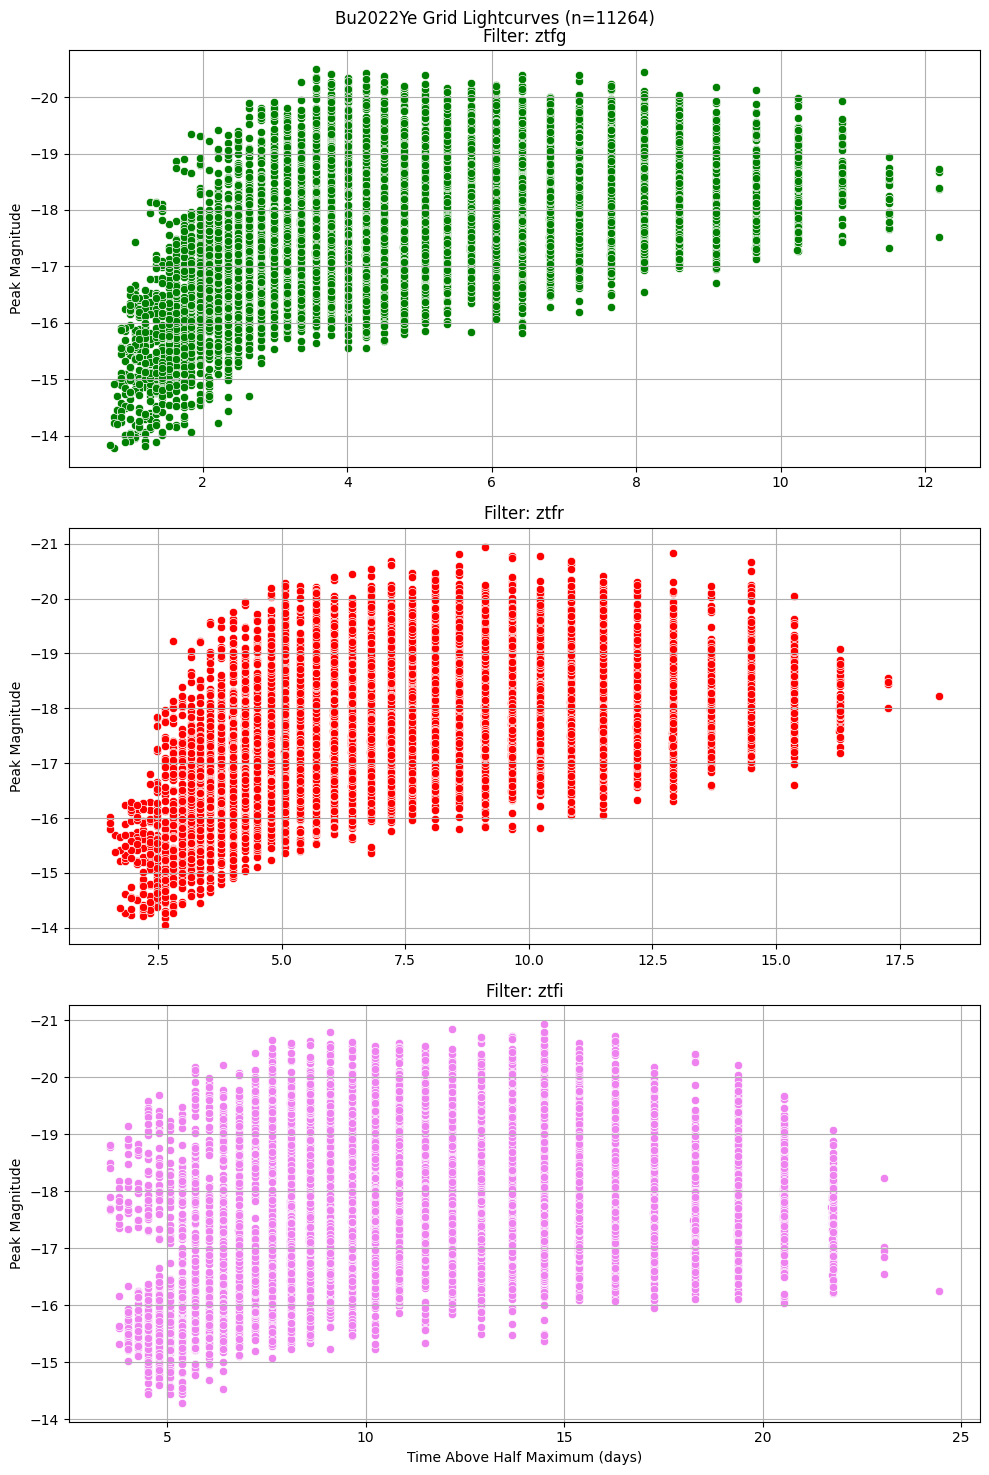

In [7]:
# Create a 3 subplot figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = ['green', 'red', 'violet']
# Loop through the filters and plot the data
for i, filter in enumerate(['ztfg', 'ztfr', 'ztfi']):
    axs[i].grid()
    df_filter = df_fwhm[df_fwhm['filter'] == filter]
    sns.scatterplot(data=df_filter, x='fwhm', y='peak_magnitude', ax=axs[i], color=colors[i]).set_title(f'Filter: {filter}')
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Time Above Half Maximum (days)') if i == 2 else axs[i].set_xlabel('')
    axs[i].set_ylabel('Peak Magnitude')
    

plt.suptitle(f'Bu2022Ye Grid Lightcurves (n={len(bulla_grid_files)})')
plt.tight_layout()
plt.show()

In [24]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
ztfredshifts.head()

,id,ra [deg],dec [deg],redshift,classification,probability,annotation origin,annotation origin key-value pair count,annotation key,annotation value,groups,Saved at,Alias,Origin,TNS
0,ZTF24aaifosg,208.285757,35.720632,0.041130,NaN,NaN,EM+GW PtAu:PtAu_gal;WIS_Test:Weizmann_Test;aca...,30;14;8;8;8;8;30;31;27;27;8;14;27;14;14;31;10;...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,0.99996;3.67;0.0412050001;20.018;0.98338;74.31...,Fritz TNS;Anomalies;Census of the Local Univer...,2024-04-04T14:55:02,NaN,Kowalski,AT 2024fkm
1,ZTF23abtycgb,54.719917,40.988617,0.020127,Type II,0.5,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;8;8;8;30;31;13;27;8;14;27;31;16;17;18...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,1;2.26;0.0201270003;19.142;0.02073;-11.61025;1...,RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-12-15T16:51:43,NaN,Kowalski,SN 2023zzk
2,ZTF23absbqun,67.334321,70.427086,0.010150,Ib,0.3,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;16;17...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"0.99997;3.83;0.012128969342353857,0.0101699997...",RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-12-11T17:35:57,NaN,Kowalski,SN 2023zaw
3,ZTF23abobwsd,19.545975,38.442367,0.024303,IIb,0.95,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;16;17...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"1;1.78;0.0243030004,0.027229231425611067;18.04...",RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-11-01T20:23:27,NaN,Kowalski,SN 2023wdd
4,ZTF23abjwgre,359.024463,29.377942,0.022608,Type II;Type II,0.66;0.8,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;31;16...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"0.99997;2.52;0.022608473896980286,0.022826008,...",Same host SNe;RCF Deep Survey;Fritz TNS;Redshi...,2023-10-16T16:34:52,NaN,Kowalski,SN 2023vcg


In [25]:
objIds = list(set(ztfredshifts["id"]))
print(objIds)

['ZTF23aaoohpy', 'ZTF21aaarlbp', 'ZTF20acutkgr', 'ZTF23abtycgb', 'ZTF22aailsqb', 'ZTF20acpkefi', 'ZTF22abfxmpc', 'ZTF20abstsxb', 'ZTF21aaafmhn', 'ZTF22aajrrzz', 'ZTF22aaajecp', 'ZTF21aaiblte', 'ZTF20acqntkr', 'ZTF22aazmooy', 'ZTF21aabxjqr', 'ZTF23aaeozpp', 'ZTF22aajkkwd', 'ZTF21abfmpwn', 'ZTF23absbqun', 'ZTF20acozryr', 'ZTF20abwysqy', 'ZTF23abgsmsg', 'ZTF22aahgvlx', 'ZTF22aabjpxh', 'ZTF23aaemgsd', 'ZTF23aaimsja', 'ZTF20acgigfo', 'ZTF22abtonmb', 'ZTF21aaeyldq', 'ZTF21aapkbav', 'ZTF24aaifosg', 'ZTF21aagwbjr', 'ZTF21abhywxv', 'ZTF21abbvvmf', 'ZTF23abcynsv', 'ZTF23abobwsd', 'ZTF23abjwgre', 'ZTF23aaxeacr', 'ZTF21aareeit', 'ZTF22abmsaxp', 'ZTF20acxooqk']


In [10]:
import os
import json
import numpy as np

dataDir = "data/"
objId = "ZTF23abhxvun"
objDirectory = os.path.join(dataDir, objId)

photometryFile = os.path.join(objDirectory, 'photometry.json')
with open(photometryFile) as f:
    photometry = json.load(f)

spectraFile = os.path.join(objDirectory, 'spectra.json')
with open(spectraFile) as f:
    spectra = json.load(f)

In [11]:
import os
import json

data_folder = 'data/'
photometry_dict = {}

for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)


In [12]:
display(photometry_dict.keys())
lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}


dict_keys(['ZTF20acpjgkt', 'ZTF20aazrcbp', 'ZTF21abvierr', 'ZTF19aapfmki', 'ZTF24aafuvmu', 'ZTF21abinaiu', 'ZTF23abobwsd', 'ZTF22aakhkoc', 'ZTF22aaigbnr', 'ZTF23abjwgre', 'ZTF22aaazmxq', 'ZTF22abpxhnj', 'ZTF21abkkcev', 'ZTF22abgtqpb', 'ZTF20aburywx', 'ZTF22aayluxo', 'ZTF21abexegc', 'ZTF23aabmzlp', 'ZTF22abijszk', 'ZTF23aajlohn', 'ZTF20acqehqq', 'ZTF20aahfqpm', 'ZTF22abbjzmp', 'ZTF24aagnnor', 'ZTF20acutkgr', 'ZTF18abffyqp', 'ZTF23aahnnrr', 'ZTF21aaafmhn', 'ZTF22abaowkz', 'ZTF23aavtwvs', 'ZTF23aajfnyc', 'ZTF23aajazzg', 'ZTF19abxjrge', 'ZTF21aavqior', 'ZTF20acpuwbf', 'ZTF22abfjnpj', 'ZTF22abntkbk', 'ZTF22abvvmti', 'ZTF20abmvjda', 'ZTF21aaabwfu', 'ZTF23aajaxvk', 'ZTF22abjibjf', 'ZTF19abacxod', 'ZTF23abcynsv', 'ZTF18aakuewf', 'ZTF23aaxeacr', 'ZTF19abobxik', 'ZTF23aaikakr', 'ZTF22abwooun', 'ZTF18abvkwlam', 'ZTF19acayojs', 'ZTF21abvczhr', 'ZTF20acxouxk', 'ZTF23absbqun', 'ZTF21aapkbav', 'ZTF21abuysnl', 'ZTF23aaoohpy', 'ZTF22aazmooy', 'ZTF23abbfrqp', 'ZTF19abxtcio', 'ZTF23abrzabc', 'ZTF24aabqdo

In [13]:
# Initialize an empty dictionary to store non-empty items
flc_dict = {}
elc_dict = {}

# Iterate over the items in lc_dict
for key, value in lc_dict.items():
    # Check if the value is not empty
    if not value.empty:
        # If the value is not empty, add it to the new dictionary
        flc_dict[key] = value
    else:
        # If the value is empty, print the key
        print(f"{key}")
        elc_dict[key] = value

# Now non_empty_lc_dict contains only the items from lc_dict that are not empty

print('number of non-empty lightcurves:', len(flc_dict))
print('number of empty lightcurves:', len(elc_dict))

ZTF20aazrcbp
ZTF22abvvmti
ZTF19abobxik
ZTF18abvkwlam
ZTF19acayojs
ZTF20abmocba
194.94985-47.75
ZTF19aankdan
ZTF18abfcmjwm
ZTF20acigmelm
ZTF20aaelulum
ZTF20ababxjv
ZTF19abuvqgw
ZTF19abrpfps
Swift-J002325.5-141701
ZTF18abukavnm
ZTF19accxzsc
ZTF18abianhw
ZTF19aasexmy
ZTF19aapuudk
ZTF19abeyvoi
Swift-J181727.0-192921
ZTF19acaxbjt
number of non-empty lightcurves: 190
number of empty lightcurves: 23


In [14]:

display(flc_dict[list(flc_dict.keys())[0]].head())
display(flc_dict[list(flc_dict.keys())[2]].head())
display(flc_dict[list(flc_dict.keys())[0]][flc_dict[list(flc_dict.keys())[0]]['filter'] == 'ztfg'])
display(flc_dict[list(flc_dict.keys())[1]][flc_dict[list(flc_dict.keys())[1]]['filter'] == 'ztfg'])

,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF20acpjgkt,NaN,NaN,ztfr,59134.150764,NaN,1,ZTF,None,None,,2083599,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.438299
1,ZTF20acpjgkt,NaN,NaN,ztfr,59135.183808,NaN,1,ZTF,None,None,,2249849,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.563700
2,ZTF20acpjgkt,NaN,NaN,ztfg,59135.227593,NaN,1,ZTF,None,None,,2249850,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.695700
3,ZTF20acpjgkt,NaN,NaN,ztfg,59136.134190,NaN,1,ZTF,None,None,,2249851,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.731001
4,ZTF20acpjgkt,NaN,NaN,ztfg,59136.135116,NaN,1,ZTF,None,None,,2083600,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.725300


,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF19aapfmki,211.43149,9.51574,atlasc,58486.670896,NaN,72,ATLAS,None,None,None,212371289,None,2022-05-05T08:35:35.880063,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,18.87
1,ZTF19aapfmki,211.43149,9.51574,atlasc,58486.679946,NaN,72,ATLAS,None,None,None,212371290,None,2022-05-05T08:35:35.880150,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,16.77
2,ZTF19aapfmki,211.43149,9.51574,atlasc,58491.669261,NaN,72,ATLAS,None,None,None,212371291,None,2022-05-05T08:35:35.880175,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,19.24
3,ZTF19aapfmki,211.43149,9.51574,atlasc,58491.680686,NaN,72,ATLAS,None,None,None,212371292,None,2022-05-05T08:35:35.880194,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,16.91
4,ZTF19aapfmki,211.43149,9.51574,atlasc,58494.634754,NaN,72,ATLAS,None,None,None,212371293,None,2022-05-05T08:35:35.880214,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,19.64


,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
2,ZTF20acpjgkt,NaN,NaN,ztfg,59135.227593,NaN,1,ZTF,None,None,,2249850,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.695700
3,ZTF20acpjgkt,NaN,NaN,ztfg,59136.134190,NaN,1,ZTF,None,None,,2249851,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.731001
4,ZTF20acpjgkt,NaN,NaN,ztfg,59136.135116,NaN,1,ZTF,None,None,,2083600,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.725300
8,ZTF20acpjgkt,NaN,NaN,ztfg,59137.225058,NaN,1,ZTF,None,None,,2249854,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.643000
12,ZTF20acpjgkt,NaN,NaN,ztfg,59138.198958,NaN,1,ZTF,None,None,,2083603,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.388901
13,ZTF20acpjgkt,NaN,NaN,ztfg,59138.199896,NaN,1,ZTF,None,None,,2249856,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.380699
14,ZTF20acpjgkt,NaN,NaN,ztfg,59139.198345,NaN,1,ZTF,None,None,,2249857,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.808901
18,ZTF20acpjgkt,NaN,NaN,ztfg,59140.157014,NaN,1,ZTF,None,None,,2083605,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.933001
19,ZTF20acpjgkt,NaN,NaN,ztfg,59140.157951,NaN,1,ZTF,None,None,,2249860,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.892500
21,ZTF20acpjgkt,NaN,NaN,ztfg,59141.207535,NaN,1,ZTF,None,None,,2249862,None,2020-11-12T16:42:24.825626,"[{'id': 14, 'created_at': '2020-10-21T06:20:33...",[],NaN,NaN,ab,20.689501


,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF21abvierr,NaN,NaN,ztfg,59423.414780,NaN,1,ZTF,None,None,None,151005848,None,2021-08-26T09:38:07.268172,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,18.374100
1,ZTF21abvierr,NaN,NaN,ztfg,59423.415729,NaN,1,ZTF,None,None,None,151005869,None,2021-08-26T09:38:07.465991,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,18.983601
5,ZTF21abvierr,NaN,NaN,ztfg,59424.422720,NaN,1,ZTF,None,None,None,151005872,None,2021-08-26T09:38:07.466113,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,19.720600
6,ZTF21abvierr,NaN,NaN,ztfg,59425.377870,NaN,1,ZTF,None,None,None,151005873,None,2021-08-26T09:38:07.466130,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,19.921600
7,ZTF21abvierr,NaN,NaN,ztfg,59425.383113,NaN,1,ZTF,None,None,None,151005849,None,2021-08-26T09:38:07.268239,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,19.934401
10,ZTF21abvierr,NaN,NaN,ztfg,59426.375012,NaN,1,ZTF,None,None,None,151005875,None,2021-08-26T09:38:07.466161,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.285601
12,ZTF21abvierr,NaN,NaN,ztfg,59427.362870,NaN,1,ZTF,None,None,None,151005877,None,2021-08-26T09:38:07.466191,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.496099
18,ZTF21abvierr,NaN,NaN,ztfg,59429.437604,NaN,1,ZTF,None,None,None,151005881,None,2021-08-26T09:38:07.466252,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.651100
21,ZTF21abvierr,NaN,NaN,ztfg,59430.403391,NaN,1,ZTF,None,None,None,151005853,None,2021-08-26T09:38:07.268310,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.591499
22,ZTF21abvierr,NaN,NaN,ztfg,59430.404329,NaN,1,ZTF,None,None,None,151005883,None,2021-08-26T09:38:07.466282,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.725401


In [15]:
## max value in ztfg for each object
max_ztfg = {key: val[val['filter'] == 'ztfg']['mag'].max() for key, val in flc_dict.items()}
max_ztfg

{'ZTF20acpjgkt': 19.781246185302734,
 'ZTF21abvierr': 20.775801097591213,
 'ZTF19aapfmki': 19.97080421447754,
 'ZTF24aafuvmu': 19.826582215257165,
 'ZTF21abinaiu': 19.08275032043457,
 'ZTF23abobwsd': 18.86380030309858,
 'ZTF22aakhkoc': nan,
 'ZTF22aaigbnr': 20.29672456794297,
 'ZTF23abjwgre': 19.771400867798498,
 'ZTF22aaazmxq': 18.464126766483016,
 'ZTF22abpxhnj': 19.456755039173572,
 'ZTF21abkkcev': 20.202800750732422,
 'ZTF22abgtqpb': 20.906700324632258,
 'ZTF20aburywx': 19.979158401489258,
 'ZTF22aayluxo': 20.238082885742188,
 'ZTF21abexegc': 19.523202896118164,
 'ZTF23aabmzlp': 19.600201080755955,
 'ZTF22abijszk': 20.244900136029013,
 'ZTF23aajlohn': nan,
 'ZTF20acqehqq': 20.1242733001709,
 'ZTF20aahfqpm': 20.773000717163086,
 'ZTF22abbjzmp': nan,
 'ZTF24aagnnor': 20.409000678668313,
 'ZTF20acutkgr': 19.979114532470703,
 'ZTF18abffyqp': 21.21310043334961,
 'ZTF23aahnnrr': 20.444799794899836,
 'ZTF21aaafmhn': 20.954500198364258,
 'ZTF22abaowkz': 19.44298968051534,
 'ZTF23aavtwvs': 

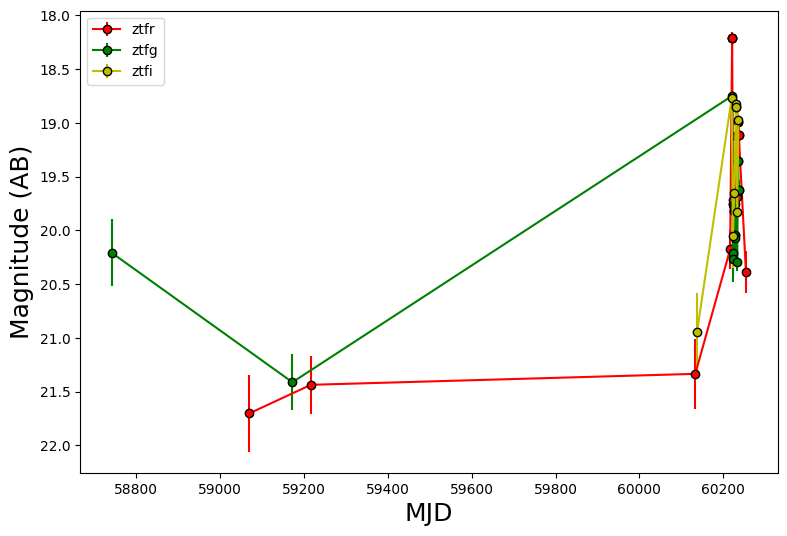

In [16]:
import matplotlib.pyplot as plt

color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'y',
              'sdssg': 'green', 'sdssr': 'red', 'sdssi': 'y',
              'atlasc': 'cyan', 'atlaso': 'orange',}

def plot_photometry(lc):

    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    ymin, ymax = np.inf, -np.inf

    for f in set(lc['filter']):
        tf = lc[lc['filter'] == f]
        
        tf_det = tf[tf['mag'] >= 3.]
        tf_ul = tf[tf['snr'] < 3]

        ax1.errorbar(tf_det['mjd'].values,
                     tf_det['mag'], yerr=tf_det['magerr'],
                     color=color_dict[f], markeredgecolor='k',
                     label=f, marker='o')
        if np.min(tf_det['mag']) < ymin:
            ymin = np.min(tf_det['mag'])
        if np.max(tf_det['mag']) > ymax:
            ymax = np.max(tf_det['mag'])

        if len(tf_ul) != 0:
            ax1.errorbar(tf_ul['mjd'].values, tf_ul['limiting_mag'],
                         markeredgecolor=color_dict[f],
                         markerfacecolor='w', fmt='v')
            plt.plot([],[], 'kv', markeredgecolor='k', markerfacecolor='w',
                     label='upper limits')

            if np.min(tf_det['limiting_mag']) < ymin:
                ymin = np.min(tf_det['limiting_mag'])
            if np.max(tf_det['limiting_mag']) > ymax:
                ymax = np.max(tf_det['limiting_mag'])
    
    plt.gca().invert_yaxis()

    ax1.set_xlabel(f"MJD", fontsize=18)
    ax1.set_ylabel("Magnitude (AB)", fontsize=18)
    plt.legend()

lc = pd.DataFrame.from_dict(photometry)
plot_photometry(lc)

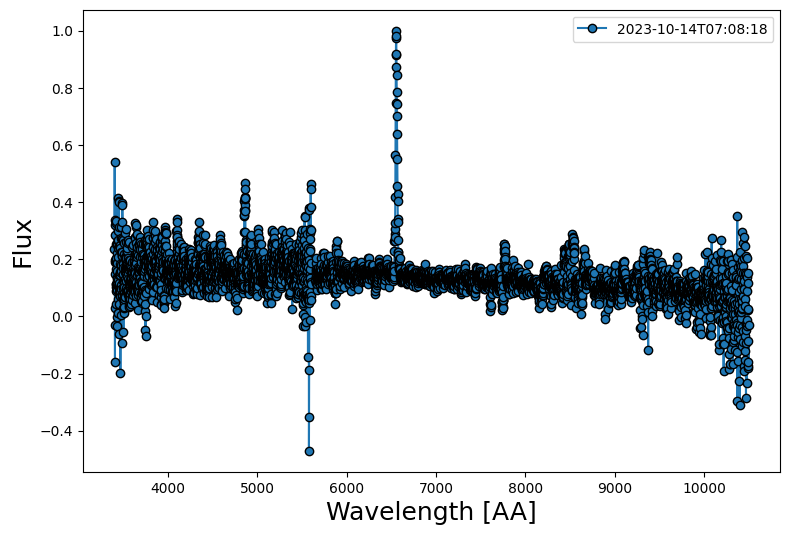

In [17]:
import matplotlib.pyplot as plt

def plot_spectra(spec):

    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    ymin, ymax = np.inf, -np.inf

    for index, row in spec.iterrows():
        
        wavelength = row['wavelengths']
        flux = np.array(row['fluxes'], dtype=np.float64)
        fluxerr = np.array(row['errors'], dtype=np.float64)
        observed_at = row['observed_at']
        
        norm = np.nanmax(flux)
        flux = flux / norm
        fluxerr = fluxerr / norm

        ax1.errorbar(wavelength,
                     flux,
                     markeredgecolor='k',
                     label=observed_at, marker='o')
        if np.nanmin(flux) < ymin:
            ymin = np.nanmin(flux)
        if np.nanmax(flux) > ymax:
            ymax = np.nanmax(flux)

    ax1.set_xlabel(f"Wavelength [AA]", fontsize=18)
    ax1.set_ylabel("Flux", fontsize=18)
    plt.legend()

spec = pd.DataFrame.from_dict(spectra['spectra'])
plot_spectra(spec)